# Download DB data using Pg-Featserv



This notebook makes use of OWSLib to connect to an OGC compliant API (PG Featserv) to download a data "collection". This is then converted to pandas dataframe.

https://owslib.readthedocs.io/en/latest/usage.html#ogc-api

In [1]:
import pandas as pd
import geopandas as gpd
from owslib.ogcapi.features import Features

In [2]:
ogc_api = 'http://10.152.63.171:9999/'

env_collect = 'postgisftw.hex_environmental_features_30m'
safegraph_collection = 'postgisftw.safegraph'
deer_home_range = 'postgisftw.deer_monthly_home_range'
deer_hex = 'postgisftw.deer_hex_summary'

env_input_csv = './data/geoda/env_60m.csv'
geoda_input_file = './data/geoda/geoda_in_60m.gpkg'
geoda_output_file = './data/geoda/geoda_out_60m.gpkg'
geo_output_file =  './data/geoda/ml_features.gpkg'
ml_output_file =  './data/geoda/ml_features.parq'

In [3]:
# !pip install owslib

## Fetch data with paging enabled
PG_Featserv only returns data in chunks. To get around this you need to loop through the requests until you get all of them.

In [4]:
def get_all_features(feature_collection, collection_name, limit = 10000, sortby=None): 
    '''
    This seems to fetch duplicates... This might be due to the DB not sorting the output? sortby=PROP
    '''
    offset = 0
    not_fetched_all = True
    appended_data = [] 

    while not_fetched_all:
        # print(f'Offset: {offset}') 
        rows = feature_collection.collection_items(collection_name, limit = limit, offset = offset, sortby = sortby)
        rows_fetched = rows['numberReturned']
        # print(f'Rows fetched: {rows_fetched}')
        gdf = gpd.GeoDataFrame.from_features(rows['features'])
        # print(gdf.iloc[0].gid, gdf.iloc[-1].gid)
        # print('=====')
        appended_data.append(gdf)
        offset = offset + rows_fetched
        not_fetched_all = rows_fetched == limit
        # print(f'Continue the work: {not_fetched_all}')
        # time.sleep(1)
        all_gdf = pd.concat(appended_data).reset_index()
        # print(f'ALL GID is unique: {all_gdf["gid"].is_unique }')
        # print(f'THIS GID is unique: {gdf["gid"].is_unique }')
        # print(f'First GID: ')
        # print(f'Last GID: ') 
        gdf = None
    return all_gdf

In [6]:
w = Features(ogc_api,timeout=5) 

In [7]:
w.collection_items(collection_id = env_collect, limit=1, offset=15000, sortby='gid')

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-77.150293745, 39.162579428],
      [-77.149932491, 39.162117933],
      [-77.149238487, 39.16213074],
      [-77.148905728, 39.162605043],
      [-77.149266977, 39.163066541],
      [-77.149960991, 39.163053733],
      [-77.150293745, 39.162579428]]]},
   'properties': {'asphalt_length': 211.64243601631247,
    'built_area': 1802.8206189032578,
    'canopy_max': 25,
    'canopy_mean': 20.9,
    'canopy_min': 16,
    'canopy_stddev': 2.947880594596734,
    'gid': 15001,
    'highway_length': None,
    'id': 15001,
    'kde_2018': None,
    'pop_total': None,
    'surface_max': 42,
    'surface_mean': 31.1,
    'surface_min': 5,
    'surface_stddev': 10.985900054160334}}],
 'numberReturned': 1,
 'timeStamp': '2024-11-20T17:07:10Z',
 'links': [{'href': 'http://10.152.63.171:9999/collections/postgisftw.hex_environmental_features_30m/items',
   'rel': 'self',
   'type': 

In [8]:
# %%time
env_df = get_all_features(w, env_collect, limit = 10000, sortby='gid')

In [9]:
# Are we getting unique GID's/ no duplicates? This should return an empty dataframe:
env_df[env_df.duplicated(['gid'], keep=False)]


,index,geometry,asphalt_length,built_area,canopy_max,canopy_mean,canopy_min,canopy_stddev,gid,highway_length,id,kde_2018,pop_total,surface_max,surface_mean,surface_min,surface_stddev


In [ ]:
# env_df.to_file(geoda_input_file, layer='env', driver="GPKG" ) 

In [10]:
%%time
mcd100_df = get_all_features(w, deer_home_range)
mcd100_df

CPU times: user 19.4 ms, sys: 71 µs, total: 19.4 ms
Wall time: 36.1 ms


,index,geometry,age_at_deployment,collar,collar_id,deer_id,month,park_name,sex,year
0,0,"POLYGON ((-76.83201 39.14236, -76.83917 39.142...",3,42972,NaN,5,2,win,f,2017
1,1,"POLYGON ((-76.83259 39.14222, -76.83269 39.142...",3,42972,NaN,5,3,win,f,2017
2,2,"POLYGON ((-76.83622 39.14064, -76.84374 39.147...",3,42972,NaN,5,4,win,f,2017
3,3,"POLYGON ((-76.83116 39.14317, -76.83533 39.147...",3,42972,NaN,5,5,win,f,2017
4,4,"POLYGON ((-76.83122 39.14732, -76.8349 39.1479...",3,42972,NaN,5,6,win,f,2017
...,...,...,...,...,...,...,...,...,...,...
625,625,"POLYGON ((-76.82979 39.21122, -76.83044 39.211...",3,42976,NaN,999,2,bl,f,2018
626,626,"POLYGON ((-76.82965 39.21141, -76.8306 39.2114...",3,42976,NaN,999,3,bl,f,2018
627,627,"POLYGON ((-76.82912 39.21112, -76.83002 39.211...",3,42976,NaN,999,4,bl,f,2018
628,628,"POLYGON ((-76.82808 39.21083, -76.8291 39.2109...",3,42976,NaN,999,5,bl,f,2018


In [11]:
%%time
deer_df = get_all_features(w, deer_hex)

CPU times: user 3.33 ms, sys: 61 µs, total: 3.39 ms
Wall time: 83.8 ms


## Get Spatial Autocorellation

LISA and/or Local Moran's I are generated using [GeoDa](https://geodacenter.github.io/). There is a python package for GeoDa made by the same people. To generate the spatial autocorrelation variables the *env_df* dataframe is saved to shapefile as a CSV, opened in GeoDa and LISA variables generated for all environmental variables, saved to disk and reopened here.

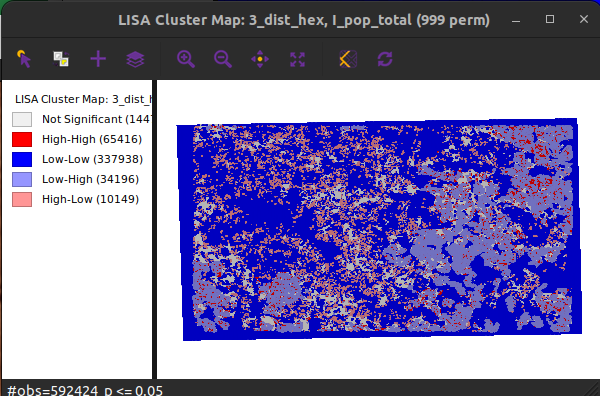

There is a python package that connects GeoDa to python: https://geodacenter.github.io/pygeoda/intro.html

I can't attest to how well it works but lets give it a try

In [ ]:
# import pygeoda
# geoda_env = pygeoda.open(env_df)
# knn36_w = pygeoda.knn_weights(geoda_env, 36)
# knn36_w.save_weights('./data/geoda/knn36_w.gal', 'something', 'gid', geoda_env['gid'])

In [ ]:
env_df_with_lisa = gpd.read_file(geoda_output_file, layer='env' )
# env_df_with_lisa = env_df_with_lisa.set_crs('epsg:4326') 

In [ ]:
deer_df[deer_df['avg_speed'] > 0]

In [16]:
# Merge the monthly hull into total hull.
# home_range_by_deer = mcd100_df.dissolve(by='deer_id')
# home_range_by_deer.to_file('./data/geoda/homerange.gpkg', layer='env', driver="GPKG" ) 
# home_range_by_deer = home_range_by_deer.set_crs('epsg:4326')

## Merge data to get training cells
Let's find the cells in the environmnetal data that is contained within the deer's home range. This should give us cells where a deer has been as well as some cells that the deer avoided.

## Build Class labels for the deer data

In [12]:
# Find the env features that intersect with the total hull
training_features = gpd.sjoin(env_df_with_lisa, home_range_by_deer, how="inner")
# Join the Deer Labels onto the training_features
training_features = training_features.merge(deer_df, on='gid', how='left') 
training_features = training_features.drop(['geometry_y'], axis=1) 

NameError: name 'env_df_with_lisa' is not defined

In [ ]:
training_features.to_file(geo_output_file, layer='env', driver="GPKG")
training_features.to_parquet(ml_output_file) 

In [ ]:
training_features.iloc[1]